# Clipping Rio Grande Riparian Zones

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import json
import requests
import time
from requests.auth import HTTPBasicAuth
from osgeo import gdal
import subprocess
import datetime
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gp
import pathlib
from planet import Session, DataClient, OrdersClient
import geojsonio
import shutil
import rasterio.plot as show
import contextily as cx
print("packages loaded.")

packages loaded.


In [2]:
# Read in the River Shapefile
filename = "Better_flowline.shp"
filepath = os.path.join('Data/Shapefiles/', filename)
river = gp.read_file(filepath)

Visualize with a basemap to make sure it's in the right place

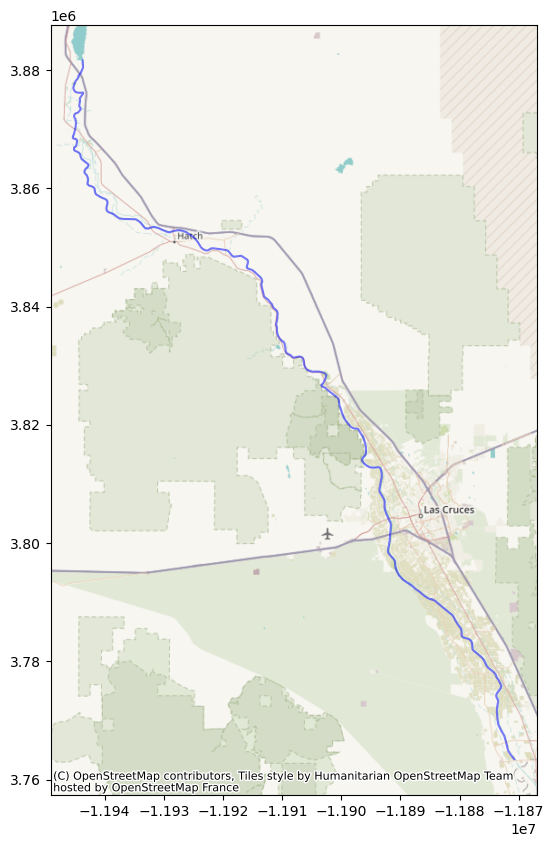

In [3]:
river_wm = river.to_crs(3857)
ax = river_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
cx.add_basemap(ax)

Creating the area round the monitoring well and putting it in the correct cooridinate system

The cooridnate system is  +init=epsg:3857 +type=crs
Total area (km^2):  0    15.912329
Name: area, dtype: float64


/Users/danielletadych/opt/miniconda3/envs/planet/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


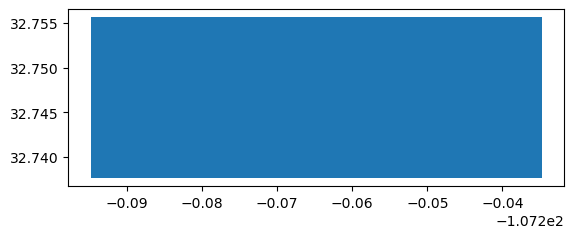

In [50]:
# Site Coordinates
# site_name = 'MES_48R'
# longitude = -106.8223400
# latitude = 32.2486900

# # MES_15R
# site_name = 'MES_15R'
# longitude = -106.8482815 # x
# latitude = 32.3510906 # y

# # RIN_2R
# site_name = 'RIN_2R'
# longitude = -107.2416600
# latitude = 32.7076400

# # RIN_9R
site_name = 'RIN_9R'
longitude = -107.2647500 
latitude = 32.7466600


# Buffer
buffer_lat = 0.009
buffer_lon = 0.03

wells= pd.DataFrame(
    {
        "Site_Name":[site_name],
        "Latitude":[latitude],
        "Longitude":[longitude]
    }
)

wells_gdf = gp.GeoDataFrame(wells,geometry=gp.points_from_xy(wells.Longitude,wells.Latitude,crs="4326"))
wells_gdf = wells_gdf.to_crs("3857")

study_area = {"type":"MultiPolygon",
              "coordinates":[[
        [
            [(longitude+buffer_lon),(latitude-buffer_lat)], #left, bottom
            [(longitude+buffer_lon),(latitude+buffer_lat)], #left, top
            [(longitude-buffer_lon),(latitude+buffer_lat)], #right, top
            [(longitude-buffer_lon),(latitude-buffer_lat)], #right, bottom
            [(longitude+buffer_lon),(latitude-buffer_lat)] #left, bottom
         ]
         ]]}

# site_name = 'test'
with open('AOI/'+site_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(study_area, f, ensure_ascii=False, indent=4)

gdf = gp.read_file('AOI/'+site_name+'.json')
gdf.plot()

tost = gdf.copy()
tost= tost.to_crs({'init': 'epsg:3857'})
print("The cooridnate system is ",tost.crs)
tost["area"] = tost['geometry'].area/ 10**6
print("Total area (km^2): ",tost['area'])

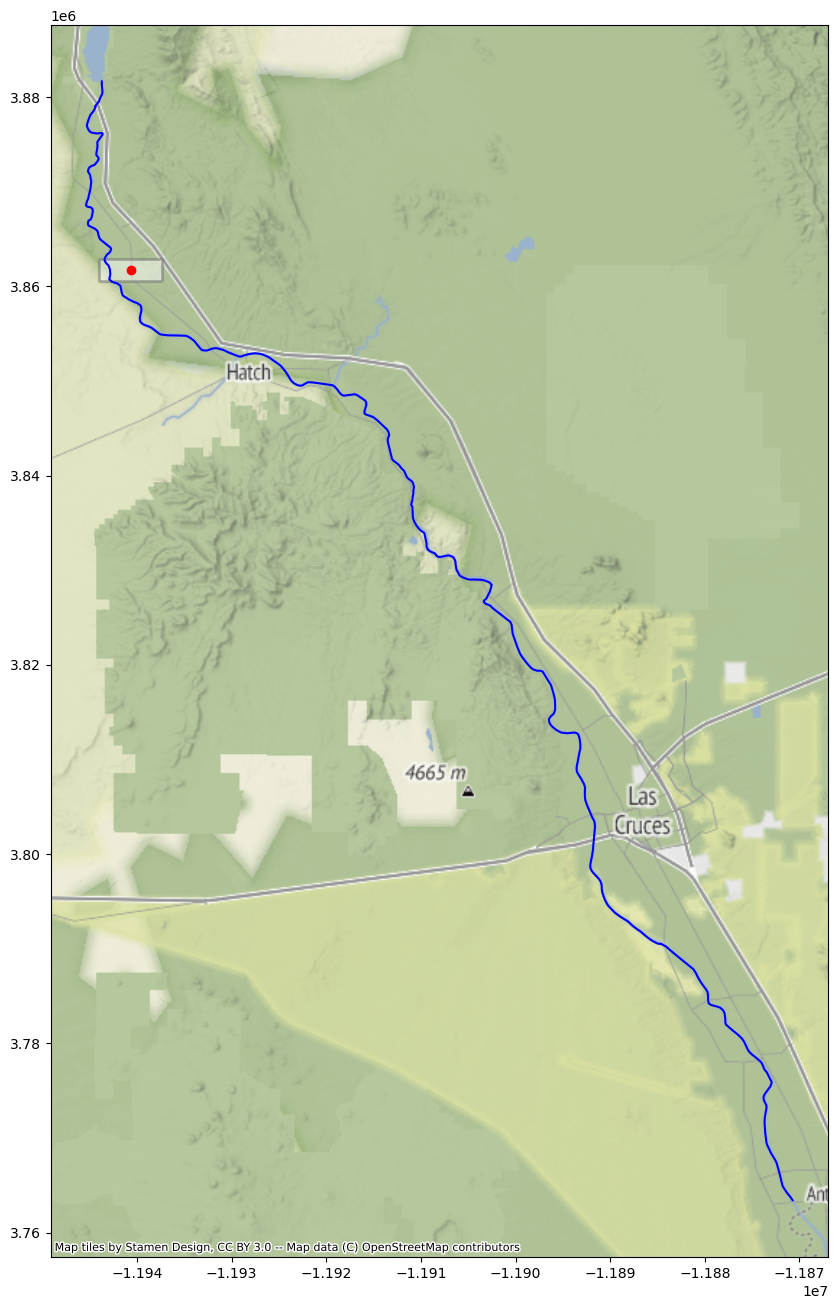

In [51]:
# ax = tost.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
# river_wm.plot()

fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_wm.plot(ax=ax, color='b')
cx.add_basemap(ax)

Clipping the River to just close to our monitor well

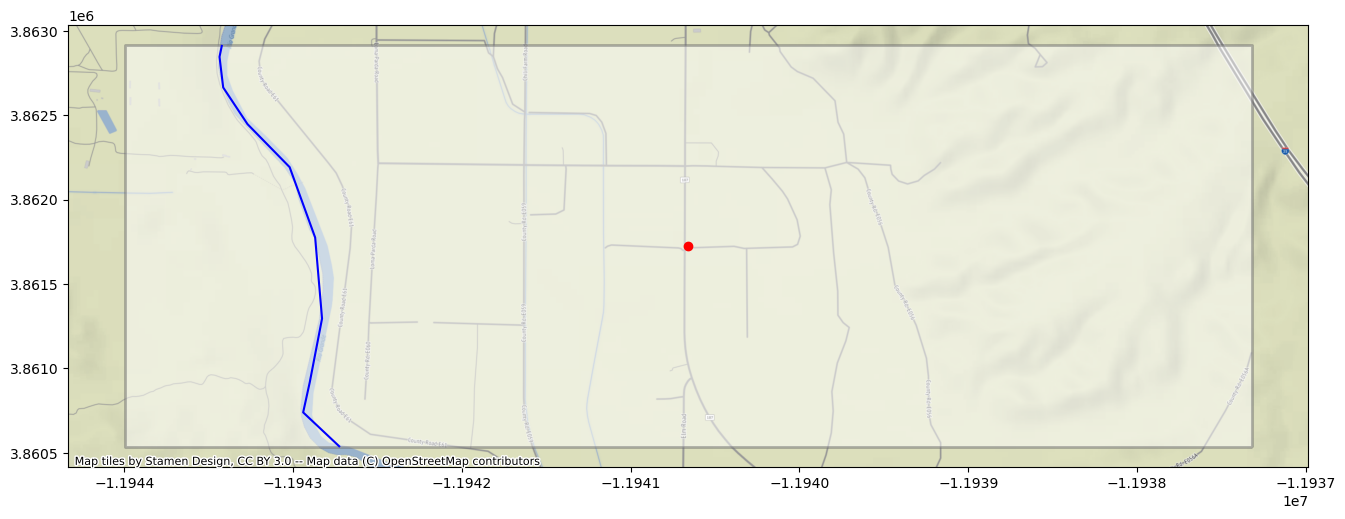

In [52]:
river_clip = gp.clip(river_wm,tost)
fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax,color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_clip.plot(ax=ax, color='b')
cx.add_basemap(ax)

Set the distance for the riparian zone around the river.  From the map we can see where roads are located, which line agricultural fields, so we want as little overlap as possible.

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_937/2391988555.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


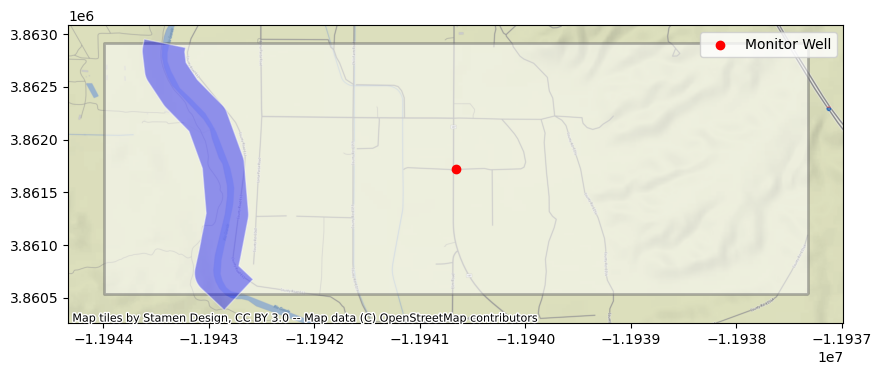

In [53]:
# set buffering distance (meters)
distance = 200
river_buffer = river_clip.buffer(distance,cap_style=2)

fig, ax = plt.subplots(figsize=(10, 10))

tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
river_buffer.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
ax.legend()
cx.add_basemap(ax)


Change the coordinate system to one with lat/lon

<Axes: >

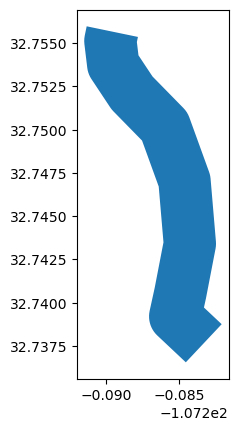

In [54]:
converted = river_buffer.to_crs(4326)
converted.plot()

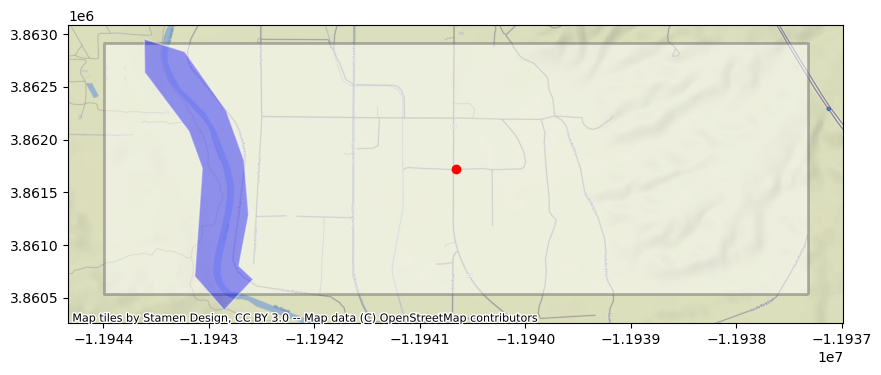

In [55]:
# Making it not so complicated of a polygon
simplified = converted.simplify(0.0006)

visualize_simplify = simplified.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))
tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
visualize_simplify.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
# ax.legend()
cx.add_basemap(ax)

Save the file

In [57]:
with open('AOI/'+site_name+'_riverbuffer.geojson' , 'w') as file:
    file.write(simplified.to_json())

In [59]:
# Write shapefile for later

simplified.to_file('AOI/'+site_name+'_simplified.shp')

## Now for creating an AOI for a larger river

In [83]:
# Set the site name
site_name = "Santa_Cruz"

In [84]:
# Read in the River Shapefile
filename = "Santa_Cruz.shp"
filepath = os.path.join('Data/Shapefiles/', filename)
river = gp.read_file(filepath)

Visualize with a basemap to make sure it's in the right place

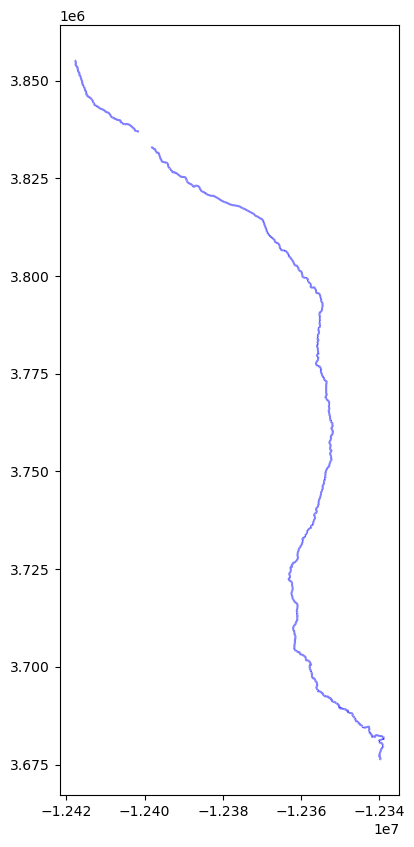

In [85]:
river_wm = river.to_crs(3857)
ax = river_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
# cx.add_basemap(ax)

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_78070/2835055423.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


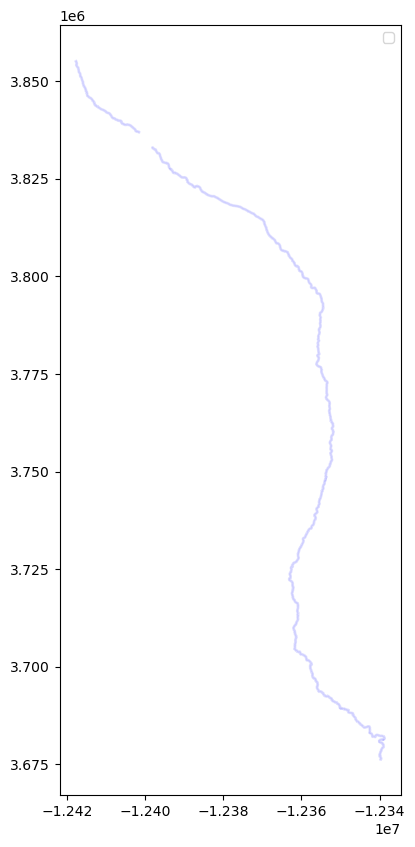

In [86]:
# set buffering distance (meters)
distance = 200
river_buffer = river_wm.buffer(distance,cap_style=2)

fig, ax = plt.subplots(figsize=(10, 10))

river_buffer.plot(ax=ax, color='b',alpha = 0.1,edgecolor='b',label="AOI")
ax.legend()
# cx.add_basemap(ax)


Change the coordinate system to one with lat/lon

<Axes: >

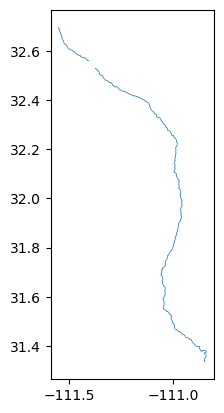

In [87]:
converted = river_buffer.to_crs(4326)
converted.plot()

<Axes: >

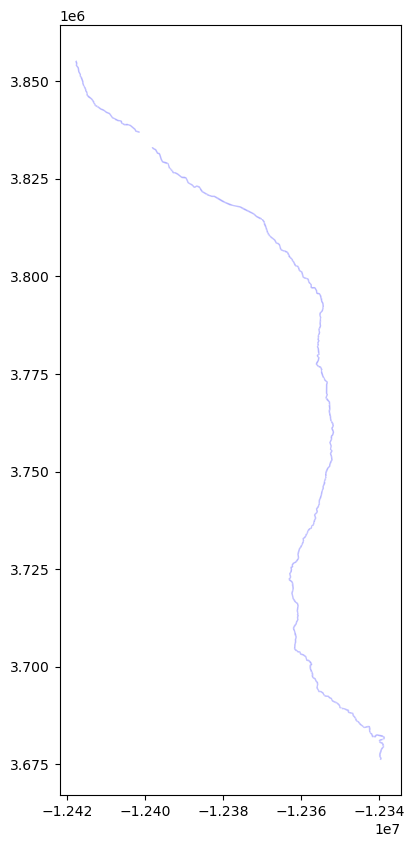

In [88]:
# Making it not so complicated of a polygon
simplified = converted.simplify(0.0006)

visualize_simplify = simplified.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))
visualize_simplify.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
# ax.legend()
# cx.add_basemap(ax)

Save the file

In [89]:
with open('AOI/'+site_name+'_riverbuffer.geojson' , 'w') as file:
    file.write(simplified.to_json())

In [90]:
# Write shapefile for later

simplified.to_file('AOI/'+site_name+'_simplified.shp')